In [1]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
from qiskit import IBMQ
from qiskit_experiments.framework import (
    ExperimentData,
    ExperimentDecoder,
    ExperimentEncoder,
)
from qiskit_research.mzm_generation import KitaevHamiltonianAnalysis

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q-internal", group="deployed", project="default")

In [24]:
# db_experiment_id = '20676939-0b16-4e86-ba4a-b0af9c10b3c0' # 8 qubits guadalupe (ok)
db_experiment_id = '960a6482-1a98-4509-96d3-2c46ac35b733' # 7 qubits guadalupe (good, dd only)
# db_experiment_id = "4bd5c93f-e6b9-458c-85c6-d3d005ddd9dd"  # 6 qubits guadalupe (good)

# retrieve data
data = ExperimentData.load(db_experiment_id, provider.service("experiment"))

# save data to local disk
params = data.metadata["params"]
filename = f"data/{params.filename}.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
with open(filename, "w") as f:
    json.dump(data, f, cls=ExperimentEncoder)

print(params.filename)

2022-03-07T20:59:31.311810_ibmq_guadalupe_n7


In [25]:
# # load data from local disk

# filename = "2022-04-28T16:09:47.070717_ibmq_quito_n3"

# with open(f"data/{filename}.json") as f:
#     data = json.load(f, cls=ExperimentDecoder)

In [26]:
%%time
# run analysis
analysis = KitaevHamiltonianAnalysis()
data = analysis.run(data, replace_results=True)
data.block_for_results()

CPU times: user 2min 5s, sys: 2min 39s, total: 4min 45s
Wall time: 38.3 s


<ExperimentData[KitaevHamiltonianExperiment], backend: ibmq_guadalupe, status: ExperimentStatus.DONE, experiment_id: 960a6482-1a98-4509-96d3-2c46ac35b733>

In [27]:
params = data.metadata["params"]

# load results
fidelity_witness_avg = data.analysis_results("fidelity_witness_avg").value
energy_exact = data.analysis_results("energy_exact").value
energy = data.analysis_results("energy").value
energy_error = data.analysis_results("energy_error").value
bdg_energy_exact = data.analysis_results("bdg_energy_exact").value
bdg_energy = data.analysis_results("bdg_energy").value
edge_correlation_exact = data.analysis_results("edge_correlation_exact").value
edge_correlation = data.analysis_results("edge_correlation").value
number_exact = data.analysis_results("number_exact").value
number = data.analysis_results("number").value
parity_exact = data.analysis_results("parity_exact").value
parity = data.analysis_results("parity").value
site_correlation_exact = data.analysis_results("site_correlation_exact").value
site_correlation = data.analysis_results("site_correlation").value

# create plot directory
PLOT_DIR = f"plots/{params.filename}"
os.makedirs(PLOT_DIR, exist_ok=True)

# set plot options
dpi = 150
filetype = "pdf"

print(params)

KitaevHamiltonianExperimentParameters(timestamp='2022-03-07T20:59:31.311810', backend_name='ibmq_guadalupe', qubits=[15, 12, 13, 14, 11, 8, 5], n_modes=7, tunneling_values=[-1], superconducting_values=[1], chemical_potential_values=[0, 0.75, 1.5, 2.25, 3], occupied_orbitals_list=[(), (0, 1, 2, 3, 4, 5, 6), (0,), (1, 2, 3, 4, 5, 6), (1,), (0, 2, 3, 4, 5, 6)], dynamical_decoupling_sequences=['XY4pm'], pulse_scaling=False, num_twirled_circuits=0, seed=None)


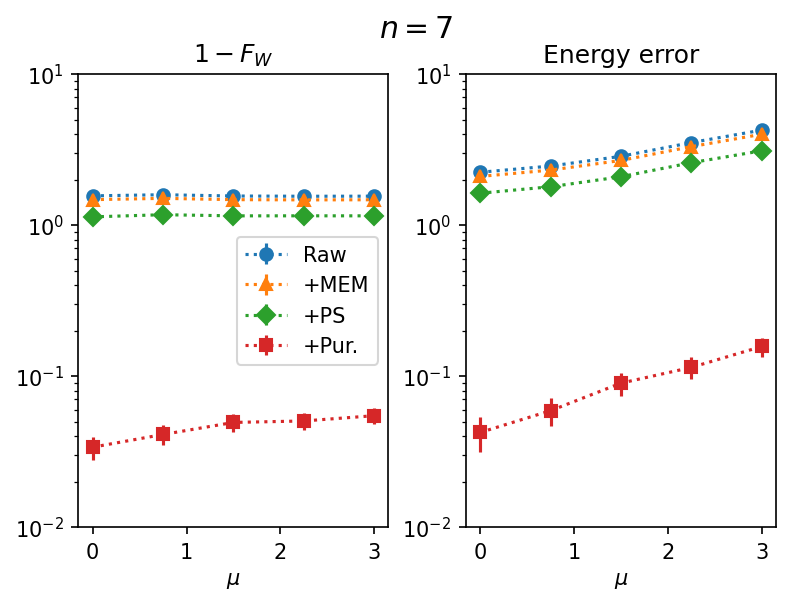

In [29]:
# plot fidelity witness and average energy error
# dd_sequence = None
dd_sequence = "XY4pm"

fig, (ax1, ax2) = plt.subplots(1, 2, dpi=dpi)
fig.subplots_adjust(wspace=0.25)

values, stddev = fidelity_witness_avg[dd_sequence]["raw"]
ax1.errorbar(
    params.chemical_potential_values,
    1 - values,
    yerr=2 * stddev,
    fmt="o:",
    label="Raw",
)
values, stddev = fidelity_witness_avg[dd_sequence]["mem"]
ax1.errorbar(
    params.chemical_potential_values,
    1 - values,
    yerr=2 * stddev,
    fmt="^:",
    label="+MEM",
)
values, stddev = fidelity_witness_avg[dd_sequence]["ps"]
ax1.errorbar(
    params.chemical_potential_values,
    1 - values,
    yerr=2 * stddev,
    fmt="D:",
    label="+PS",
)
values, stddev = fidelity_witness_avg[dd_sequence]["pur"]
ax1.errorbar(
    params.chemical_potential_values,
    1 - values,
    yerr=2 * stddev,
    fmt="s:",
    label="+Pur.",
)
ax1.set_xlabel(r"$\mu$")
ax1.set_title(r"$1 - F_W$")
ax1.set_yscale("log")
ax1.set_ylim(1e-2, 10)

values, stddev = energy_error[dd_sequence]["raw"]
ax2.errorbar(
    params.chemical_potential_values,
    values,
    yerr=2 * stddev,
    fmt="o:",
    label="Raw",
)
values, stddev = energy_error[dd_sequence]["mem"]
ax2.errorbar(
    params.chemical_potential_values,
    values,
    yerr=2 * stddev,
    fmt="^:",
    label="+MEM",
)
values, stddev = energy_error[dd_sequence]["ps"]
ax2.errorbar(
    params.chemical_potential_values,
    values,
    yerr=2 * stddev,
    fmt="D:",
    label="+PS",
)
values, stddev = energy_error[dd_sequence]["pur"]
ax2.errorbar(
    params.chemical_potential_values,
    values,
    yerr=2 * stddev,
    fmt="s:",
    label="+Pur.",
)
ax2.set_xlabel(r"$\mu$")
ax2.set_title(r"Energy error")
ax2.set_yscale("log")
ax2.set_ylim(1e-2, 10)
ax1.legend(loc='best')
fig.suptitle(fr"$n = {params.n_modes}$",
             size='x-large',
             # y=0.02
            )

data.add_figures(fig, "fidelity_witness", overwrite=True)
plt.savefig(f"{PLOT_DIR}/fidelity_witness_dd-{dd_sequence}_n{params.n_modes}.{filetype}")
plt.show()

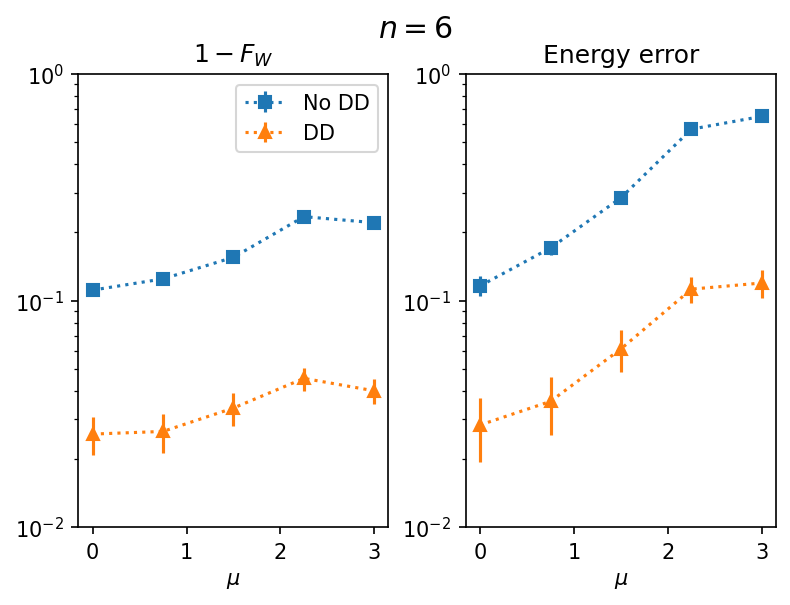

In [20]:
# plot fidelity witness and average energy error, dd vs no dd

fig, (ax1, ax2) = plt.subplots(1, 2, dpi=dpi)
fig.subplots_adjust(wspace=0.25)

values, stddev = fidelity_witness_avg[None]["pur"]
ax1.errorbar(
    params.chemical_potential_values,
    1 - values,
    yerr=2 * stddev,
    fmt="s:",
    label="No DD",
)
values, stddev = fidelity_witness_avg[dd_sequence]["pur"]
ax1.errorbar(
    params.chemical_potential_values,
    1 - values,
    yerr=2 * stddev,
    fmt="^:",
    label="DD",
)
ax1.set_xlabel(r"$\mu$")
ax1.set_title(r"$1 - F_W$")
ax1.set_yscale("log")
ax1.set_ylim(1e-2, 1)

values, stddev = energy_error[None]["pur"]
ax2.errorbar(
    params.chemical_potential_values,
    values,
    yerr=2 * stddev,
    fmt="s:",
    label="No DD",
)
values, stddev = energy_error[dd_sequence]["pur"]
ax2.errorbar(
    params.chemical_potential_values,
    values,
    yerr=2 * stddev,
    fmt="^:",
    label="DD",
)
ax2.set_xlabel(r"$\mu$")
ax2.set_title(r"Energy error")
ax2.set_yscale("log")
ax2.set_ylim(1e-2, 1)
ax1.legend(loc='best')
fig.suptitle(fr"$n = {params.n_modes}$",
             size='x-large',
             # y=0.02
            )

data.add_figures(fig, "fidelity_witness_dd", overwrite=True)
plt.savefig(f"{PLOT_DIR}/fidelity_witness_dd_compare_n{params.n_modes}.{filetype}")
plt.show()

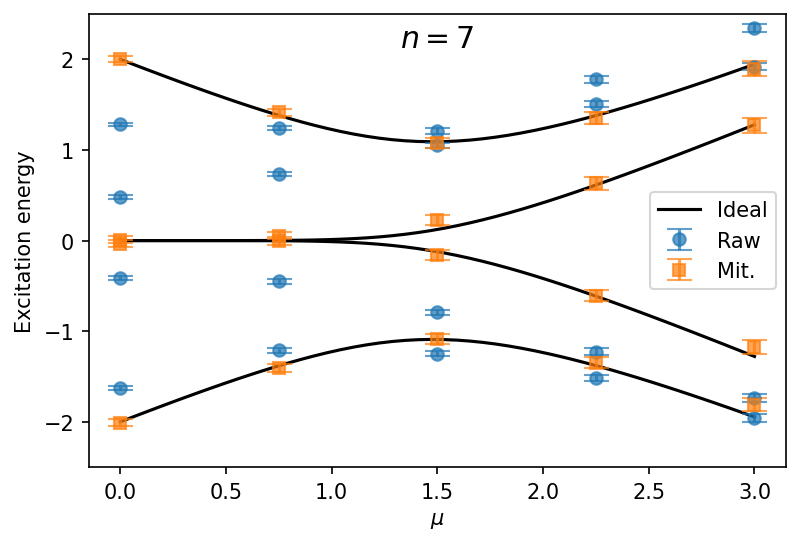

In [30]:
# plot BdG energies
fig, ax = plt.subplots(dpi=dpi)
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]
capsize = 6

for i, energies in enumerate(bdg_energy_exact[0]):
    ax.plot(bdg_energy_exact[1], energies, color="black", label=None if i else "Ideal")

threshold = len(bdg_energy[dd_sequence]["raw"][0]) // 2
raw_values, raw_stddev = bdg_energy[dd_sequence]["raw"]
mit_values, mit_stddev = bdg_energy[dd_sequence]["pur"]

for i in range(threshold):
    error1 = ax.errorbar(
        params.chemical_potential_values,
        raw_values[i],
        yerr=2 * raw_stddev[i],
        fmt="o",
        capsize=capsize,
        color=colors[0],
        alpha=0.7,
        label=None if i else "Raw",
    )
    ax.errorbar(
        params.chemical_potential_values,
        raw_values[threshold + i],
        yerr=2 * raw_stddev[threshold + i],
        fmt="o",
        capsize=capsize,
        color=colors[0],
        alpha=0.7,
    )
    error2 = ax.errorbar(
        params.chemical_potential_values,
        mit_values[i],
        yerr=2 * mit_stddev[i],
        fmt="s",
        capsize=capsize,
        color=colors[1],
        alpha=0.7,
        label=None if i else "Mit.",
    )
    ax.errorbar(
        params.chemical_potential_values,
        mit_values[threshold + i],
        yerr=2 * mit_stddev[threshold + i],
        fmt="s",
        capsize=capsize,
        color=colors[1],
        alpha=0.7,
    )
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"Excitation energy")
ax.set_ylim(-2.5, 2.5)
ax.legend(loc="right")
ax.set_title(fr"$n = {params.n_modes}$", size='x-large', y=0.90)

data.add_figures(fig, "bdg_energy", overwrite=True)
plt.savefig(f"{PLOT_DIR}/bdg_energy_dd-{dd_sequence}_n{params.n_modes}.{filetype}")

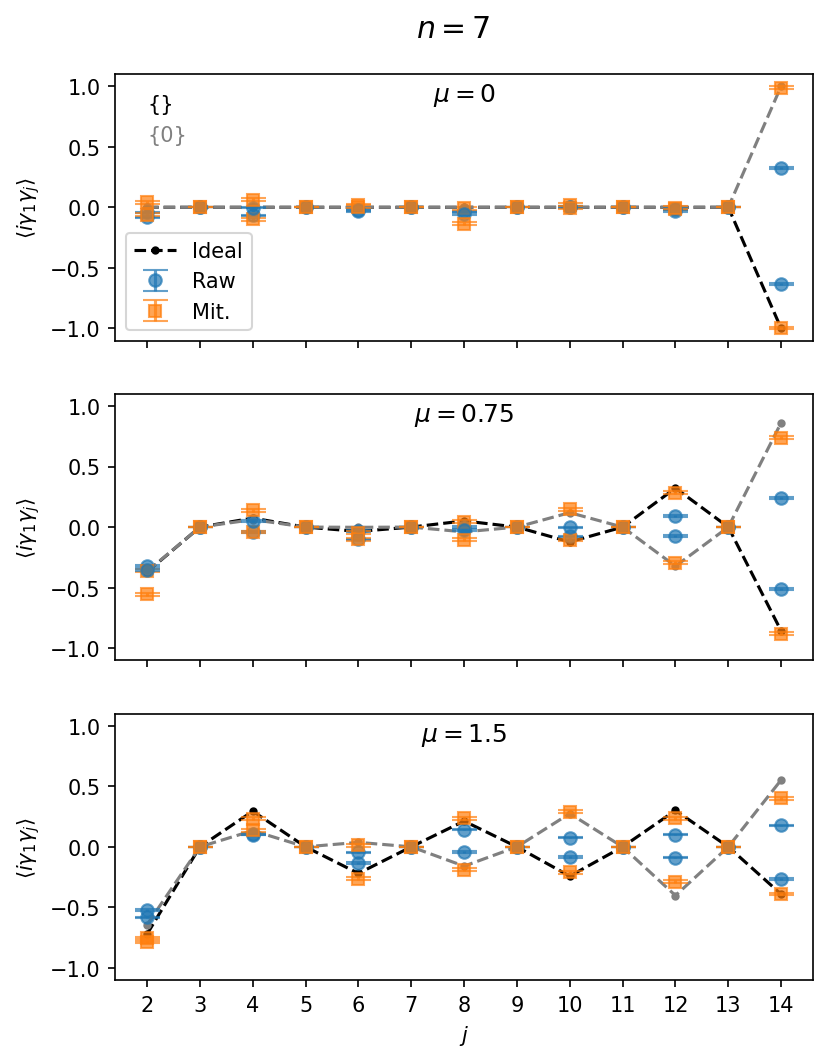

In [21]:
### plot site correlation
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]
capsize = 6

xvals = range(2, 2 * params.n_modes + 1)

chemical_potentials_to_plot = params.chemical_potential_values[:3]
# chemical_potentials_to_plot = params.chemical_potential_values
occupied_orbitals_to_plot = params.occupied_orbitals_list[0:3:2]
# occupied_orbitals_to_plot = params.occupied_orbitals_list[2:4]

fig, axes = plt.subplots(len(chemical_potentials_to_plot), 1, dpi=dpi, figsize=(6, 8))
# fig.subplots_adjust(hspace=0.7)
for index, (ax, chemical_potential) in enumerate(
    zip(axes, chemical_potentials_to_plot)
):
    for i, occupied_orbitals in enumerate(occupied_orbitals_to_plot):
        # this_parity = int(parity_exact[occupied_orbitals][0][index])
        ideal_color = "black" if i == 0 else "gray"
        ideal_text = str(list(occupied_orbitals)).replace('[', '{').replace(']', '}')
        if index == 0:
            ax.text(2.0, 0.8 - i * 0.25, ideal_text, color=ideal_color)
        site_correlations = site_correlation_exact[
            chemical_potential, occupied_orbitals
        ]
        ax.plot(
            xvals,
            site_correlations,
            ".--",
            color=ideal_color,
            label="Ideal" if not occupied_orbitals else None,
        )
        (vals, stddevs) = site_correlation[dd_sequence]["raw"][
            chemical_potential, occupied_orbitals
        ]
        ax.errorbar(
            xvals,
            vals,
            yerr=2 * np.array(stddevs),
            fmt="o",
            capsize=capsize,
            color=colors[0],
            alpha=0.7,
            label=None if i else "Raw",
        )
        (vals, stddevs) = site_correlation[dd_sequence]["pur"][
            chemical_potential, occupied_orbitals
        ]
        ax.errorbar(
            xvals,
            vals,
            yerr=2 * np.array(stddevs),
            fmt="s",
            capsize=capsize,
            color=colors[1],
            alpha=0.7,
            label=None if i else "Mit.",
        )
        ax.set_ylim(-1.1, 1.1)
    ax.set_ylabel(r"$\langle i \gamma_1 \gamma_j \rangle$")
    ax.set_xticks(xvals)
    if index == 0:
        ax.legend(loc='lower left')
    if index == len(axes) - 1:
        ax.set_xlabel(r"$j$")
    else:
        ax.tick_params(axis='x', labelbottom=False)

    ax.set_title(fr"$\mu={chemical_potential}$", y=0.85)

fig.suptitle(fr"$n = {params.n_modes}$", size='x-large', y=0.93)
data.add_figures(fig, f"site_correlation", overwrite=True)
plt.savefig(f"{PLOT_DIR}/site_correlation_dd-{dd_sequence}_n{params.n_modes}.{filetype}")
plt.show()

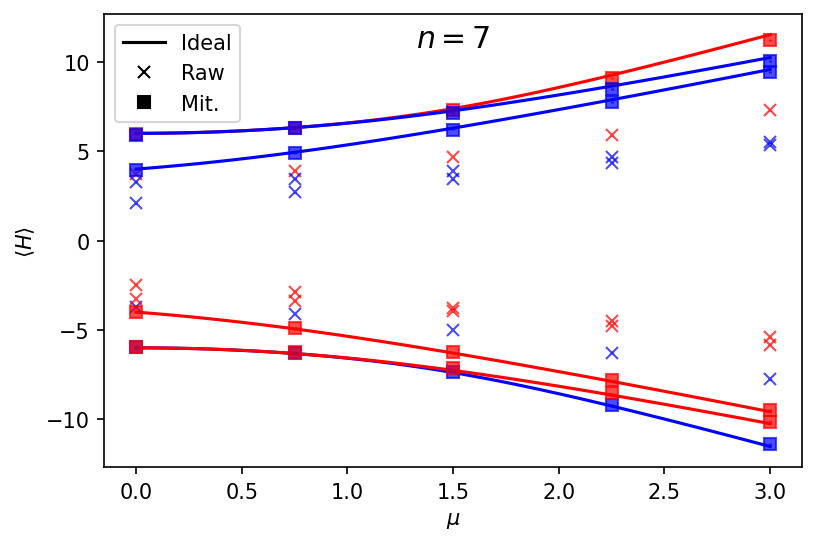

In [29]:
# plot energy
fig, ax = plt.subplots(dpi=dpi)

for occupied_orbitals, (energies, xvals) in energy_exact.items():
    ax.plot(
        xvals,
        energies,
        # label = "Ideal" if not i else None,
        color="red" if len(occupied_orbitals) % 2 else "blue",
    )
for occupied_orbitals, (energies, stddevs) in energy[dd_sequence]["raw"].items():
    ax.errorbar(
        params.chemical_potential_values,
        energies,
        yerr=2 * np.array(stddevs),
        fmt="x",
        # label="Raw" if not i else None,
        color="red" if len(occupied_orbitals) % 2 else "blue",
        alpha=0.7,
    )
for occupied_orbitals, (energies, stddevs) in energy[dd_sequence]["pur"].items():
    ax.errorbar(
        params.chemical_potential_values,
        energies,
        yerr=2 * np.array(stddevs),
        fmt="s",
        # label = "Mit." if not i else None,
        color="red" if len(occupied_orbitals) % 2 else "blue",
        alpha=0.7,
    )
ax.plot(
    [],
    [],
    label="Ideal",
    color="black"
)
ax.errorbar(
    [],
    [],
    fmt='x',
    label="Raw",
    color="black"
)
ax.errorbar(
    [],
    [],
    fmt='s',
    label="Mit.",
    color="black"
)
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\langle H \rangle$")
ax.set_title(fr"$n = {params.n_modes}$", size='x-large', y=0.90)
ax.legend()

data.add_figures(fig, "energy", overwrite=True)
plt.savefig(f"{PLOT_DIR}/energy_dd-{dd_sequence}_n{params.n_modes}.{filetype}")
plt.show()

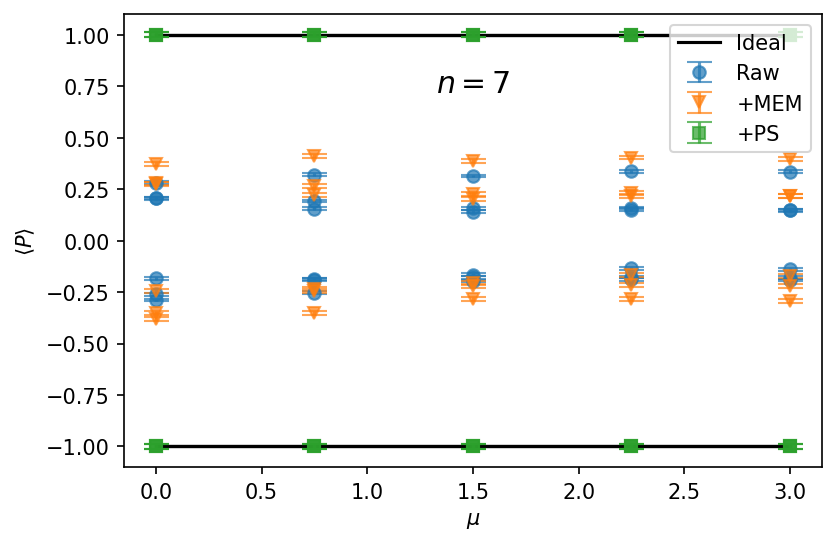

In [30]:
# plot parity
fig, ax = plt.subplots(dpi=dpi)
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]
capsize = 6

for occupied_orbitals, (parities, xvals) in parity_exact.items():
    ax.plot(
        xvals, parities, label="Ideal" if not occupied_orbitals else None, color="black"
    )

for occupied_orbitals, (parities, stddevs) in parity[dd_sequence]["raw"].items():
    label = "Raw" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        params.chemical_potential_values,
        parities,
        yerr=2 * np.array(stddevs),
        fmt="o",
        capsize=capsize,
        color=colors[0],
        alpha=0.7,
        label="Raw" if not occupied_orbitals else None,
    )
for occupied_orbitals, (parities, stddevs) in parity[dd_sequence]["mem"].items():
    ax.errorbar(
        params.chemical_potential_values,
        parities,
        yerr=2 * np.array(stddevs),
        fmt="v",
        capsize=capsize,
        color=colors[1],
        alpha=0.7,
        label="+MEM" if not occupied_orbitals else None,
    )
for occupied_orbitals, (parities, stddevs) in parity[dd_sequence]["ps"].items():
    ax.errorbar(
        params.chemical_potential_values,
        parities,
        yerr=2 * np.array(stddevs),
        fmt="s",
        capsize=capsize,
        color=colors[2],
        alpha=0.7,
        label="+PS" if not occupied_orbitals else None,
    )
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\langle P \rangle$")
ax.set_ylim(-1.1, 1.1)
ax.legend()
ax.set_title(fr"$n = {params.n_modes}$", size='x-large', y=0.80)

data.add_figures(fig, "parity", overwrite=True)
plt.savefig(f"{PLOT_DIR}/parity_dd-{dd_sequence}_n{params.n_modes}.{filetype}")
plt.show()

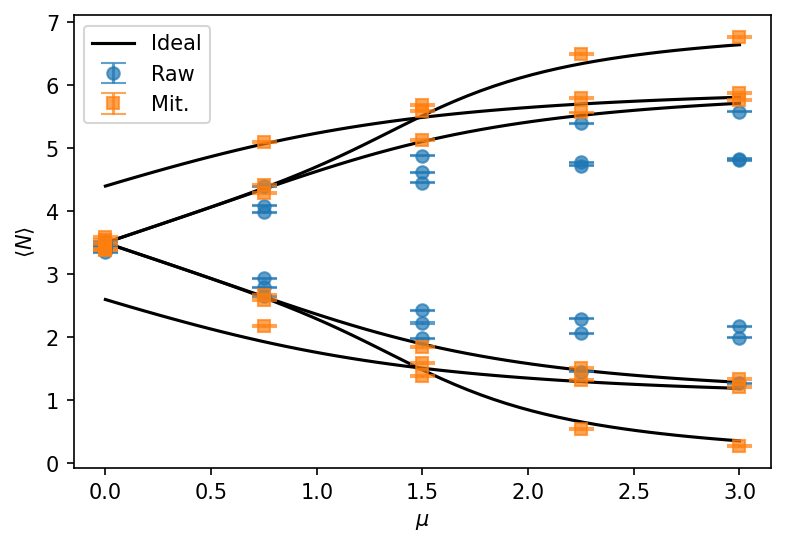

In [31]:
# plot number
fig, ax = plt.subplots(dpi=dpi)
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]
capsize = 6

for occupied_orbitals, (numbers, xvals) in number_exact.items():
    ax.plot(
        xvals,
        numbers,
        label="Ideal" if not occupied_orbitals else None,
        color="black",
    )

for occupied_orbitals, (numbers, stddevs) in number[dd_sequence]["raw"].items():
    ax.errorbar(
        params.chemical_potential_values,
        numbers,
        yerr=2 * np.array(stddevs),
        fmt="o",
        capsize=capsize,
        color=colors[0],
        alpha=0.7,
        label="Raw" if not occupied_orbitals else None,
    )
for occupied_orbitals, (numbers, stddevs) in number[dd_sequence]["pur"].items():
    ax.errorbar(
        params.chemical_potential_values,
        numbers,
        yerr=2 * np.array(stddevs),
        fmt="s",
        capsize=capsize,
        color=colors[1],
        alpha=0.7,
        label="Mit." if not occupied_orbitals else None,
    )
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\langle N \rangle$")
ax.legend()

data.add_figures(fig, "number", overwrite=True)
plt.savefig(f"{PLOT_DIR}/number_dd-{dd_sequence}_n{params.n_modes}.{filetype}")
plt.show()

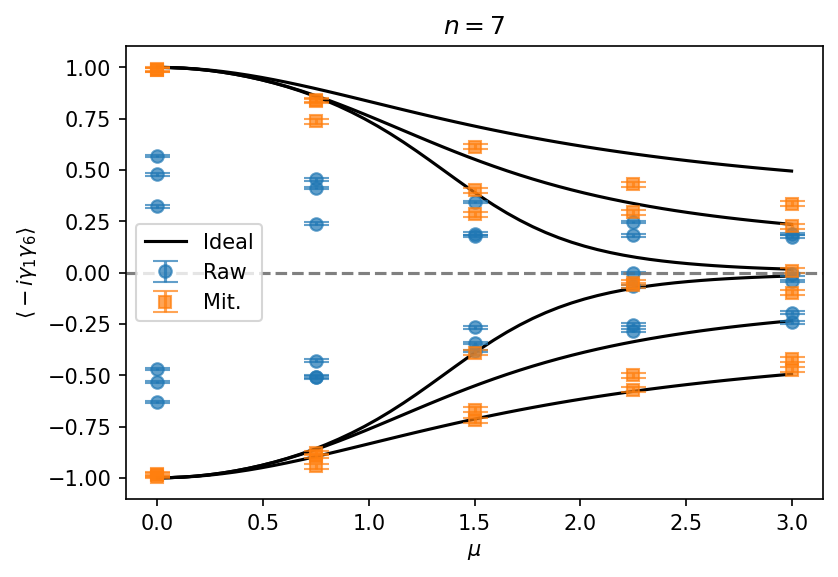

In [32]:
# plot edge correlation
fig, ax = plt.subplots(dpi=dpi)
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]
capsize = 6

for occupied_orbitals, (values, xvals) in edge_correlation_exact.items():
    ax.plot(
        xvals,
        values,
        color="black",
        label="Ideal" if not occupied_orbitals else None,
    )

for occupied_orbitals, (values, stddevs) in edge_correlation[dd_sequence][
    "raw"
].items():
    ax.errorbar(
        params.chemical_potential_values,
        values,
        yerr=2 * np.array(stddevs),
        fmt="o",
        capsize=capsize,
        color=colors[0],
        alpha=0.7,
        label="Raw" if not occupied_orbitals else None,
    )
for occupied_orbitals, (values, stddevs) in edge_correlation[dd_sequence][
    "pur"
].items():
    ax.errorbar(
        params.chemical_potential_values,
        values,
        yerr=2 * np.array(stddevs),
        fmt="s",
        capsize=capsize,
        color=colors[1],
        alpha=0.7,
        label="Mit." if not occupied_orbitals else None,
    )
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\langle -i \gamma_1 \gamma_6 \rangle$")
ax.axhline([0], color="gray", linestyle="--")
ax.legend(loc="center left")
ax.set_title(fr"$n = {params.n_modes}$")

data.add_figures(fig, "edge_correlation", overwrite=True)
plt.savefig(f"{PLOT_DIR}/edge_correlation_dd-{dd_sequence}_n{params.n_modes}.{filetype}")
plt.show()